# 1. Import des modules

In [1]:
import pandas as pd
import lestpy.lbm_model as lp

# 2. Import des données

Chemin et nom du fichier

In [2]:
path, fichier = "C:/Users/TTfr/Documents/Python/Analyses DOE - MD/desactivation/","resultats DOE Val.xlsx"

Import des données dans python avec pandas

In [3]:
donnees = pd.read_excel(path + fichier, decimal=',')

Nettoyage des données et des colonnes obsolètes

In [4]:
donnees.drop(columns = donnees.columns[0], inplace=True)
donnees.tail()

,pH,Temperatures (°C),Temps (min),[Acide pectique (%m/m)],X10 1,C3 1570,X10 1500/1,C1 1500/1,Hel1,C3 0614/2,PR1 FL,PR1 0120/1
25,6,65,15,5,0.383933,0.198000,0.438200,0.303567,0.444400,0.735933,0.004800,0.004800
26,6,65,15,5,0.436600,0.555767,0.462100,0.354133,0.551400,0.491900,0.005733,0.000000
27,6,65,15,0,0.024467,0.028133,0.088533,0.121500,0.029400,0.363033,0.024467,0.028133
28,6,65,15,0,0.008700,0.021750,0.040350,0.090100,0.015050,0.408650,0.036450,0.022100
29,6,65,15,0,0.074867,0.035433,0.087633,0.263000,0.018733,0.554067,0.000000,0.018767


Liste des colonnes pour séparer entre X et y

In [5]:
donnees.columns

Index(['pH', 'Temperatures (°C)', 'Temps (min)', '[Acide pectique (%m/m)]',
       'X10 1', 'C3 1570', 'X10 1500/1', 'C1 1500/1', 'Hel1', 'C3 0614/2',
       'PR1 FL', 'PR1 0120/1'],
      dtype='object')

In [6]:
y = donnees[['X10 1','C3 1570', 'X10 1500/1', 'C1 1500/1', 'Hel1', 'C3 0614/2', 'PR1 FL', 'PR1 0120/1']]
X = donnees[['pH', 'Temperatures (°C)', 'Temps (min)', '[Acide pectique (%m/m)]']]
X.head()

,pH,Temperatures (°C),Temps (min),[Acide pectique (%m/m)]
0,3,50,15,5
1,9,50,15,5
2,3,80,15,5
3,9,80,15,5
4,3,65,5,5


In [7]:
y.head()

,X10 1,C3 1570,X10 1500/1,C1 1500/1,Hel1,C3 0614/2,PR1 FL,PR1 0120/1
0,0.503600,0.541167,0.574600,0.624733,0.705133,0.722133,0.041933,0.000000
1,0.634000,0.661000,0.540000,0.503000,0.440000,0.430000,0.107617,0.033583
2,0.018733,0.551333,0.104033,0.137800,0.043533,0.681500,0.029317,0.032650
3,0.089767,0.048667,0.473533,0.354233,0.398967,0.981267,0.000000,0.009533
4,0.515650,0.379983,0.464750,0.520250,0.589483,0.520817,0.040733,0.000333


In [8]:
model = lp.LBM_Regression()

In [9]:
model.transform(X, y)

['X_xor_Y', 'X_or_Y', 'X_or_not_Y', 'X_and_Y', 'X_and_not_Y', 'X_if_Y', 'X_if_not_Y', 'X_if_Y_average', 'X_average_if_Y', 'Neither_X_nor_Y_extreme', 'both_X_Y_average', 'X_like_Y', 'Sum_X_Y', 'Difference_X_Y']
method = variable instant
calculé en 0.172 secondes


In [10]:
model.fit()

summary of the model for X10 1:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     12.18
Date:                Thu, 19 May 2022   Prob (F-statistic):           2.46e-06
Time:                        14:02:41   Log-Likelihood:                 30.954
No. Observations:                  30   AIC:                            -41.91
Df Residuals:                      20   BIC:                            -27.90
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.431

In [11]:
model.print_model()

model for target "X10 1"
The value of X10 1 is high if:
   Coefficient                                          Parameter  Std Error
0       -0.432   Temperatures (°C) or not [Acide pectique (%m/m)]      0.135
1       -0.658                    pH if Temperatures (°C) average      0.110
2       -0.477               Temperatures (°C) or not Temps (min)      0.137
3       -0.353              both pH and Temperatures (°C) average      0.106
4       -0.679           Temperatures (°C) if Temps (min) average      0.181
5        0.686               Sum of pH and Temperatures (°C) high      0.219
6        0.203  both Temps (min) and [Acide pectique (%m/m)] a...      0.105
7       -0.184            Temps (min) xor [Acide pectique (%m/m)]      0.104
8       -0.170                     pH xor [Acide pectique (%m/m)]      0.104



model for target "C3 1570"
The value of C3 1570 is high if:
   Coefficient                                          Parameter  Std Error
0       -1.211                    

In [12]:
for i in y:
    model.fitting_score(y[i])

Fitting score for target "X10 1"
                R²  adj-R²  calc-Q²
model score  0.846   0.777    0.639
Fitting score for target "C3 1570"
                R²  adj-R²  calc-Q²
model score  0.619    0.52    0.378
Fitting score for target "X10 1500/1"
                R²  adj-R²  calc-Q²
model score  0.909   0.861    0.754
Fitting score for target "C1 1500/1"
                R²  adj-R²  calc-Q²
model score  0.857   0.782    0.613
Fitting score for target "Hel1"
                R²  adj-R²  calc-Q²
model score  0.892   0.835    0.734
Fitting score for target "C3 0614/2"
                R²  adj-R²  calc-Q²
model score  0.898   0.859    0.739
Fitting score for target "PR1 FL"
                R²  adj-R²  calc-Q²
model score  0.936   0.902    0.882
Fitting score for target "PR1 0120/1"
                R²  adj-R²  calc-Q²
model score  0.917   0.891    0.856


In [13]:
graf = lp.Display(model)

Fitting score for target "X10 1"
                R²  adj-R²  calc-Q²
model score  0.846   0.777    0.639


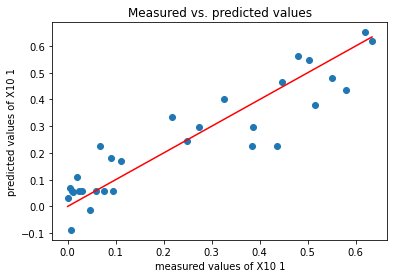

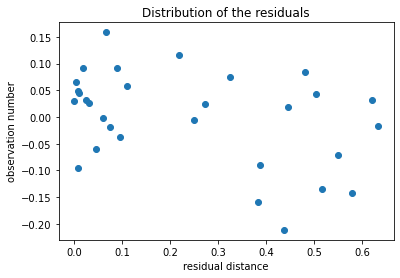

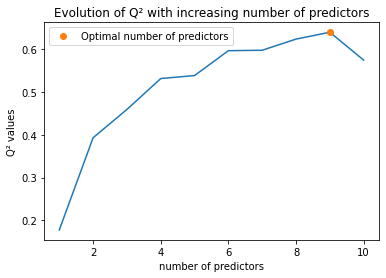

Fitting score for target "C3 1570"
                R²  adj-R²  calc-Q²
model score  0.619    0.52    0.378


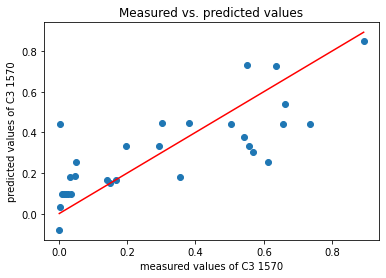

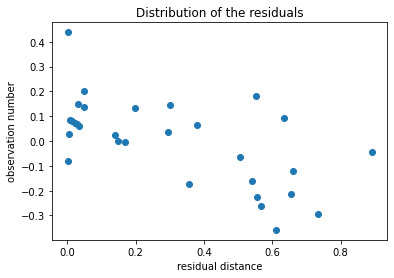

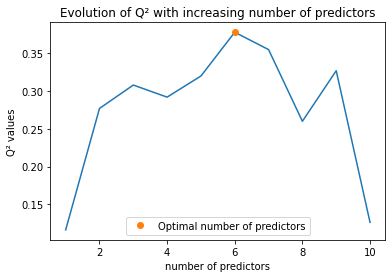

Fitting score for target "X10 1500/1"
                R²  adj-R²  calc-Q²
model score  0.909   0.861    0.754


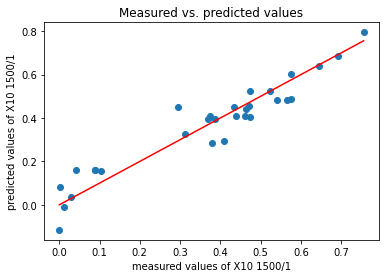

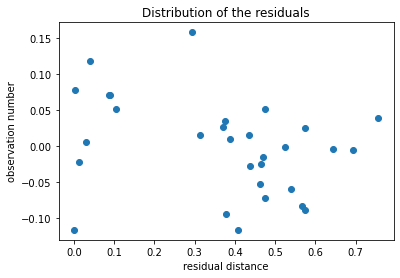

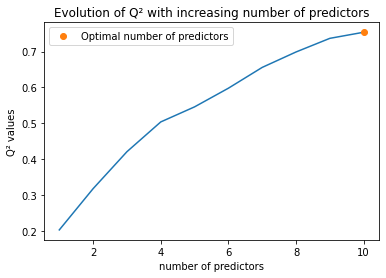

Fitting score for target "C1 1500/1"
                R²  adj-R²  calc-Q²
model score  0.857   0.782    0.613


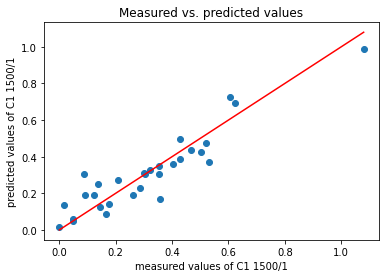

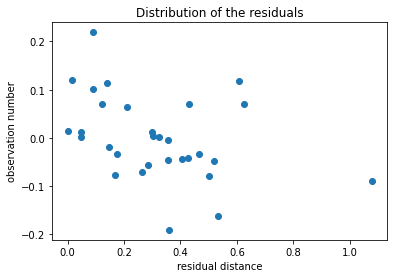

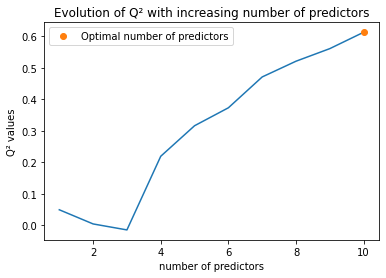

Fitting score for target "Hel1"
                R²  adj-R²  calc-Q²
model score  0.892   0.835    0.734


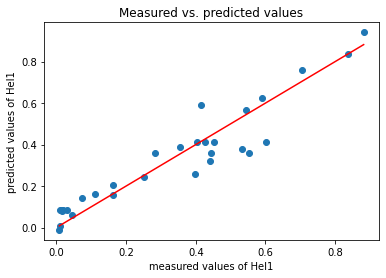

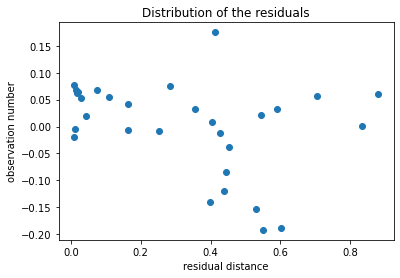

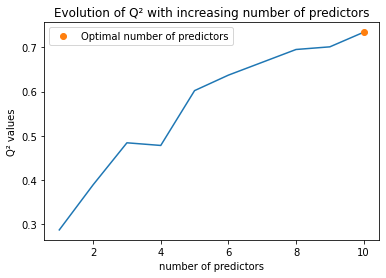

Fitting score for target "C3 0614/2"
                R²  adj-R²  calc-Q²
model score  0.898   0.859    0.739


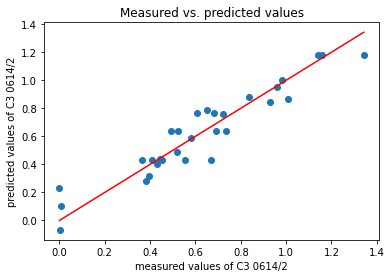

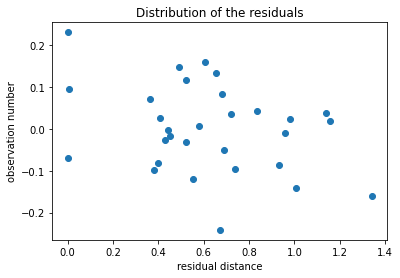

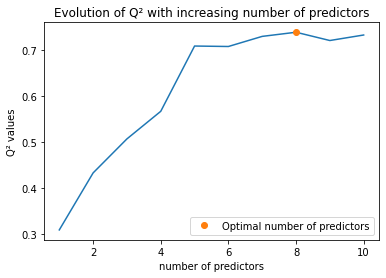

Fitting score for target "PR1 FL"
                R²  adj-R²  calc-Q²
model score  0.936   0.902    0.882


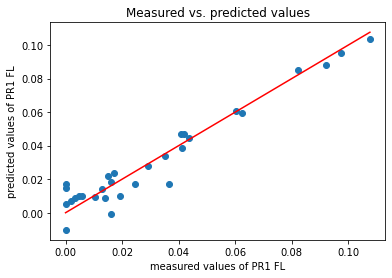

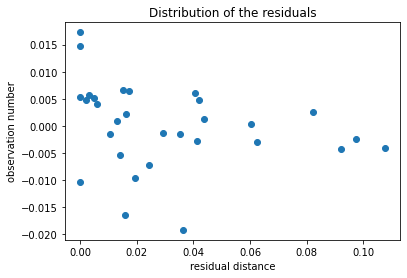

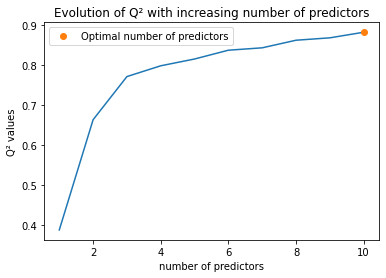

Fitting score for target "PR1 0120/1"
                R²  adj-R²  calc-Q²
model score  0.917   0.891    0.856


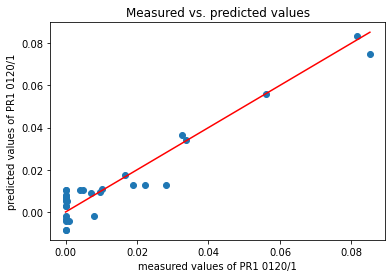

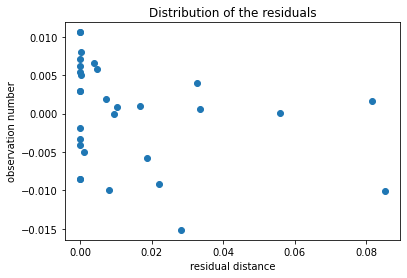

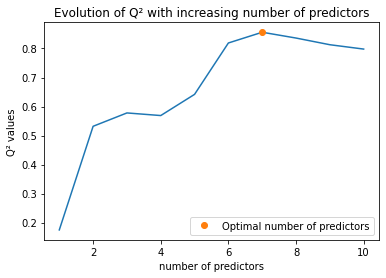

In [14]:
graf.describe()

In [18]:
domain, mix = model.features_analysis(X)
target = ['minimize'] * 8
print(target)

['minimize', 'minimize', 'minimize', 'minimize', 'minimize', 'minimize', 'minimize', 'minimize']


In [20]:
model.optimize(domain, target)

size = 10000
                         Mean of the 5 best results  Best result
pH                                            9.000        9.000
Temperatures (°C)                            65.000       65.000
Temps (min)                                  25.000       25.000
[Acide pectique (%m/m)]                       0.000        0.000
PredX10 1                                    -0.090       -0.090
PredC3 1570                                  -0.079       -0.079
PredX10 1500/1                               -0.135       -0.135
PredC1 1500/1                                 0.004        0.004
PredHel1                                     -0.345       -0.345
PredC3 0614/2                                 0.097        0.097
PredPR1 FL                                    0.025        0.025
PredPR1 0120/1                               -0.002       -0.002
desirability                                  0.781        0.781


,pH,Temperatures (°C),Temps (min),[Acide pectique (%m/m)],PredX10 1,PredC3 1570,PredX10 1500/1,PredC1 1500/1,PredHel1,PredC3 0614/2,PredPR1 FL,PredPR1 0120/1,desirability
0,6,80,25,10,0.390280,0.847265,0.697347,0.626907,0.357976,1.658891,0.004440,-0.004848,0.326795
1,3,80,25,5,0.261164,0.731600,0.004988,0.190773,0.655161,1.058739,0.016433,0.020673,0.464221
2,6,80,25,0,0.203314,0.031409,0.277810,0.096017,0.351229,0.697868,-0.000487,-0.005516,0.615575
3,3,65,5,0,0.481467,0.305088,0.647638,0.624273,0.555414,0.772303,0.066211,0.007747,0.388614
4,6,50,5,5,0.070143,0.441319,0.080853,0.134854,0.006549,-0.067456,0.087927,0.075045,0.512110
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3,50,5,5,0.034510,0.378421,0.174388,0.391658,0.374814,0.108853,0.075183,0.032600,0.529456
9996,9,65,5,0,-0.086105,-0.079041,0.113631,0.024751,-0.162710,0.108331,0.053106,0.007747,0.704935
9997,3,80,15,0,0.108426,0.417722,0.192994,0.252938,0.209442,0.770416,0.021021,0.032946,0.556068
9998,9,65,25,5,0.169676,0.253191,0.452853,0.386634,0.141655,0.787450,0.038517,-0.004135,0.544081


In [21]:
model.optimize(domain, target)

size = 10000
                         Mean of the 5 best results  Best result
pH                                            9.000        9.000
Temperatures (°C)                            65.000       65.000
Temps (min)                                  25.000       25.000
[Acide pectique (%m/m)]                       0.000        0.000
PredX10 1                                    -0.090       -0.090
PredC3 1570                                  -0.079       -0.079
PredX10 1500/1                               -0.135       -0.135
PredC1 1500/1                                 0.004        0.004
PredHel1                                     -0.345       -0.345
PredC3 0614/2                                 0.097        0.097
PredPR1 FL                                    0.025        0.025
PredPR1 0120/1                               -0.002       -0.002
desirability                                  0.781        0.781


,pH,Temperatures (°C),Temps (min),[Acide pectique (%m/m)],PredX10 1,PredC3 1570,PredX10 1500/1,PredC1 1500/1,PredHel1,PredC3 0614/2,PredPR1 FL,PredPR1 0120/1,desirability
0,9,50,25,0,0.133782,0.152517,0.088190,-0.214208,-0.651514,-0.320723,0.110776,0.074375,0.552233
1,9,65,25,5,0.169676,0.253191,0.452853,0.386634,0.141655,0.787450,0.038517,-0.004135,0.544081
2,6,65,15,5,0.225363,0.331564,0.410509,0.307779,0.359421,0.638983,0.009870,0.010590,0.539995
3,9,65,15,10,0.243928,0.182729,0.688008,0.272233,0.589106,0.865821,0.008820,-0.008490,0.474247
4,6,80,25,5,0.296797,0.441319,0.396783,0.361664,0.414629,1.178380,0.018500,-0.001821,0.486557
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,3,50,5,5,0.034510,0.378421,0.174388,0.391658,0.374814,0.108853,0.075183,0.032600,0.529456
9996,6,50,15,0,0.334328,0.150334,0.327705,0.127048,0.243665,0.282465,0.095185,0.083250,0.437180
9997,3,65,25,5,0.563948,0.445255,0.600960,0.228923,0.941278,0.844119,0.006788,-0.004135,0.361257
9998,9,65,15,5,0.167225,0.253191,0.523810,0.264822,0.415879,0.610649,0.011777,0.000615,0.539817
